In [1]:
!pip install -q -r requirements.txt

In [2]:
%matplotlib inline
import pandas as pd 
import matplotlib.pyplot as plt
import keras 
import numpy as np 


2023-10-15 14:33:00.630351: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-15 14:33:00.641220: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 14:33:00.743154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 14:33:00.743231: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 14:33:00.743475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### load data

For LSTM, we need to prepare the sequence data to make it in shape of (samples, time steps, features). 

We also normalize the data to make it in similar scale.

In [3]:
data=pd.read_csv('input/data.csv', index_col=0, parse_dates=[0])
print(data.shape)
data.head()

(427, 12)


,total_purchase_amt,total_redeem_amt,Interest_O_N,Interest_1_W,Interest_2_W,Interest_1_M,Interest_3_M,Interest_6_M,Interest_9_M,Interest_1_Y,mfd_daily_yield,mfd_7daily_yield
date,,,,,,,,,,,,
2013-07-01,0.165344,0.036072,4.456,5.423,6.040,6.8800,5.295,4.2390,4.2820,4.4125,1.5787,6.307
2013-07-02,0.147781,0.016678,3.786,4.750,5.074,5.8000,5.211,4.2344,4.2808,4.4070,1.5461,6.174
2013-07-03,0.138790,0.038872,3.400,4.242,4.658,5.2000,5.148,4.2300,4.2796,4.4022,1.4670,6.034
2013-07-04,0.093242,0.041854,3.348,3.938,4.464,5.1020,5.029,4.2287,4.2776,4.4000,1.4223,5.903
2013-07-05,0.059284,0.018043,3.380,3.816,4.295,4.7885,4.939,4.2273,4.2749,4.4000,1.3845,5.739


In [4]:
def process(df):
    lag1df = df.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['total_purchase_amt']].join(lag1df)
    return df.fillna(0) 
def normalize(df):
    for col in df.columns:
        if col != 'total_purchase_amt':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df 
data=process(data)
data=normalize(data)
print(data.shape)


(427, 13)


In [5]:
def make_series(data):
    series=[]
    for i in range(len(data)-14):
        subdf=data[i:i+14]
        series.append( (subdf.index[-1], subdf['total_purchase_amt'].values[-1], subdf.drop('total_purchase_amt', axis=1).values))
    return series
series=make_series(data)
print(series[0][0],series[0][1].shape,series[0][2].shape)
train=series[:-30]
test=series[-30:]

2013-07-14 00:00:00 () (14, 12)


### train


In [6]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =14

In [7]:
inputs = keras.layers.Input(shape=(14,12))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mae")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 12)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5760      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5793 (22.63 KB)
Trainable params: 5793 (22.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
x=np.array([x[2].reshape(14,12) for x in train])
y=np.array([x[1] for x in train])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(383, 14, 12)
(383,)
Epoch 1/100
12/12 [==============================] - 1s 9ms/step - loss: 0.5472
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.3854
Epoch 3/100
12/12 [==============================] - 0s 7ms/step - loss: 0.3300
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.3069
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.3046
Epoch 6/100
12/12 [==============================] - 0s 8ms/step - loss: 0.2961
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.2909
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.2790
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 0.2768
Epoch 10/100
12/12 [==============================] - 0s 7ms/step - loss: 0.2702
Epoch 11/100
12/12 [==============================] - 0s 6ms/step - loss: 0.2735
Epoch 12/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2618
Epoch 13/100
12/

### reuslts

In [9]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train ])
train_pred.head()

12/12 [==============================] - 0s 3ms/step


,yhat
2013-07-14,0.017743
2013-07-15,0.217050
2013-07-16,0.239253
2013-07-17,0.230440
2013-07-18,0.204033


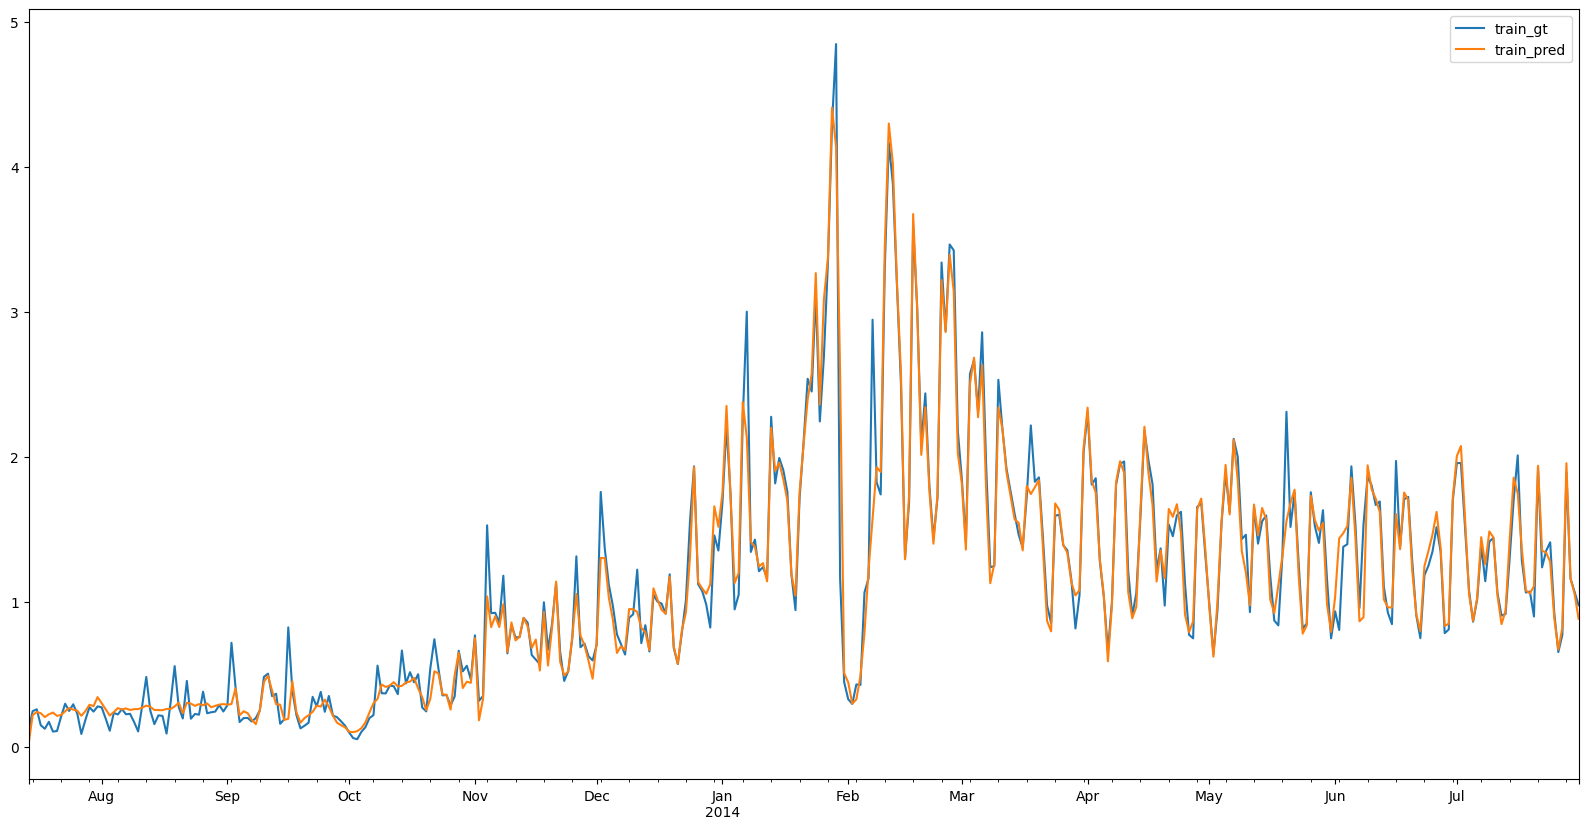

In [10]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

1/1 [==============================] - 0s 17ms/step


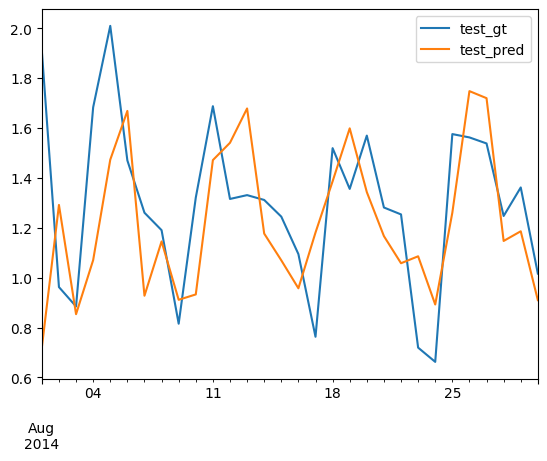

In [11]:
test_pred=model.predict(np.array([x[2].reshape(14,12) for x in test]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test ])
test_gt=pd.DataFrame([x[1] for x in test], columns=['y'], index=[x[0] for x in test ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])